# Estudo do dataset 'Crédito do Sul da Alemanha' para o modelo de credit score

### link: https://archive.ics.uci.edu/dataset/573/south+german+credit+update

### 700 créditos bons e 300 créditos ruins com 20 variáveis ​​preditoras. Dados de 1973 a 1975. Amostra estratificada de créditos reais com créditos ruins fortemente sobreamostrados. Uma matriz de custos pode ser usada.

- Características do conjunto de dados: Multivariada

- Área da matéria: Negócios

- Tarefas Associadas: Classificação, Regressão, Clustering

- Tipo de recurso: Inteiro, Real

- Instâncias: 1000

- Features: 21

### Importar bibliotecas e base de dados

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
import os

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive/')
#!cp '/content/gdrive/Shareddrives/NBA_SC - LARC/notebooks/SouthGermanCredit.asc' .

In [3]:
# Read the data from the file
ruta_carpeta_raiz = os.getcwd()
nombre_base_archivo = 'SouthGermanCredit.asc'
ruta_archivo = os.path.join(ruta_carpeta_raiz, nombre_base_archivo)

dat = pd.read_table(ruta_archivo)

# Lee los datos desde el archivo
dat = pd.read_table(r"C:\Users\Aramary\Desktop\LARC\Motor de Credito\Base de dados Alemana\SouthGermanCredit.asc", header=None)

# Elimina la primera fila (encabezados originales)
dat = dat.iloc[1:]

# Separa los elementos en la columna única y asigna nombres a las columnas
dat = dat[0].str.split(expand=True)

# Define variable names from Fahrmeir/Hamerle book
column_names = ["status", "duração", "histórico_decrédito", "objetivo", "valor",
                 "poupança", "duração_emprego", "taxa_parcela",
                 "personal_status_sex", "outros_devedores",
                 "presente_residência", "propriedade",
                 "idade", "outros planos_de_instalação",
                 "habitação", "número_créditos",
                 "trabalho", "pessoas_liable", "telefone", "trabalhador_estrangeiro",
                 "risco de crédito"]

# Asigna los nuevos nombres de las columnas
dat.columns = column_names

# Muestra los primeros registros para verificar
display(dat)

,status,duração,histórico_decrédito,objetivo,valor,poupança,duração_emprego,taxa_parcela,personal_status_sex,outros_devedores,...,propriedade,idade,outros planos_de_instalação,habitação,número_créditos,trabalho,pessoas_liable,telefone,trabalhador_estrangeiro,risco de crédito
1,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
2,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
3,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
4,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
5,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,1,24,2,3,1987,1,3,2,3,1,...,1,21,3,1,1,2,1,1,2,0
997,1,24,2,0,2303,1,5,4,3,2,...,1,45,3,2,1,3,2,1,2,0
998,4,21,4,0,12680,5,5,4,3,1,...,4,30,3,3,1,4,2,2,2,0
999,2,12,2,3,6468,5,1,2,3,1,...,4,52,3,2,1,4,2,2,2,0


In [98]:
dat.to_excel('dataset_crédito_do_Sul_da_Alemanha.xlsx')

## Analise cualitativo:

### A tabela 'dat' contém números para todas as variáveis.

- variáveis duração, valor e idade são verdadeiramente quantitativas

- variáveis taxa_parcela, presente_residência e número_crédito são quantitativos nos dados, mas na verdade são pontuações discretizadas para uma variável quantitativa subjacente e são, portanto, armazenados como fatores ordenados abaixo

- variável pessoas_liable é quantitativa nos dados, mas é de fato uma pontuação binária (menos 0 a 2 versus 3 ou mais) e, portanto, é armazenado como um fator abaixo

- todos os valores numéricos (=códigos de nível) para as variáveis categóricas (incluindo as variáveis quantitativas discretizadas), são as pontuações P2 de Häußler (1979) que pode ser usado diretamente na pontuação de crédito (maior = melhor). 

### Features:

###  'status'  : Status da conta corrente do devedor no banco (categórico)
- 1: sem conta corrente
- 2: ... <0 DM
- 3: 0<= ... <200 DM
- 4: ... >= 200 DM/salário por pelo menos 1 ano 

### 'duração' : Duração crédito em meses (quantitativo) 

### 'histórico_de_crédito' : Histórico de cumprimento de contratos de crédito anteriores ou simultâneos (categórico)                                               
-  0: atraso no pagamento no passado
-  1: conta crítica/outros créditos em outro lugar
-  2: nenhum crédito obtido/todos os créditos pagos devidamente
-  3: créditos existentes pagos devidamente até agora
-  4: todos os créditos deste banco foram devidamente reembolsados

### 'objetivo' : Finalidade para a qual o crédito é necessário (categórico)                      
-  0: outros
-  1: carro (novo)
-  2: carro (usado)
-  3: móveis/equipamentos
-  4: rádio/televisão
-  5: eletrodomésticos
-  6: reparos
-  7: educação
-  8: férias
-  9: reciclagem
- 10: negócios
     
### 'valor' : Valor do crédito em DM (quantitativo; resultado de transformação monotônica; dados reais e tipo de transformação desconhecidos)   

###  'poupança' do devedor (categórico)
-  1: desconhecido/sem conta poupança
-  2: ... <100 DM
-  3: 100 <= ... <500 DM
-  4: 500 <= ... < 1000 DM
-  5: ... >= 1000 DM

### 'duração_emprego' : Duração do emprego do devedor com o empregador atual (ordinal; quantitativo discretizado)                   
-  1: desempregado
-  2: <1 ano
-  3: 1 <= ... < 4 anos
-  4: 4 <= ... < 7 anos
-  5: >= 7 anos

### 'taxa_parcela' : Parcelas do crédito como percentual da renda disponível do devedor (ordinal; quantitativo discretizado)                
-  1: >= 35
-  2: 25 <= ... <35
-  3: 20 <= ... <25
-  4: <20

### 'status_pessoal_sexo'  : Informações combinadas sobre sexo e estado civil; categórico; o sexo não pode ser recuperado da variável, pois homens solteiros e mulheres não solteiras são codificados com o mesmo código (2); as viúvas femininas não podem ser facilmente classificadas, porque a tabela de códigos não as lista em nenhuma das categorias femininas                                        
-  1: masculino: divorciado/separado
-  2: feminino: não solteiro ou masculino: solteiro
-  3: masculino: casado/viúvo
-  4: feminino: solteiro

### 'outros_devedores' : Existe outro devedor ou fiador do crédito? (categórico)               
-  1: nenhum
-  2: co-requerente
-  3: fiador

### 'presente_residência' : Tempo (em anos) que o devedor vive na residência atual (ordinal; quantitativo discretizado)                     
-  1: <1 ano
-  2: 1 <= ... < 4 anos
-  3: 4 <= ... < 7 anos
-  4: >= 7 anos

### 'propriedade' : O bem mais valioso do devedor, ou seja o código mais alto possível é usado. O código 2 é utilizado se os códigos 3 ou 4 não forem aplicáveis e houver um carro ou qualquer outro bem relevante que não se enquadre na variável. (ordinal)                                             
-  1: desconhecido/sem propriedade
-  2: carro ou outro
-  3: construção social. poupança agr./seguro de vida
-  4: imobiliário
  
### 'idade' : Idade em anos (quantitativo)

### 'outros_planos_de_instalação' : Planos de parcelamento de outros prestadores que não são banco credor (categórico)         
-  1: banco
-  2: lojas
-  3: nenhum

### 'habitação' : Tipo de habitação onde o devedor reside (categórico)          
-  1: de graça
-  2: aluguel
-  3: próprio

### 'número_créditos' : número de créditos incluindo o atual que o devedor tem (ou tinha) neste banco (ordinal, quantitativo discretizado)  
-  1: 1
-  2: 2-3
-  3: 4-5
-  4: >= 6

### 'trabalho' : Qualidade do trabalho do devedor (ordinal)
-  1: desempregado/não qualificado - não residente
-  2: não qualificado - residente
-  3: funcionário/funcionário qualificado
-  4: gerente/autoempregado/altamente qualificado. funcionário

### 'pessoas_liable' : Número de pessoas que dependem financeiramente do devedor (ou seja, têm direito a alimentos) (binário, quantitativo discretizado)        
-  1: 3 ou mais
-  2: 0 a 2

### 'telefone' : Existe telefone fixo cadastrado em nome do devedor? (binário; lembre-se que os dados são da década de 1970)                            
-  1: não
-  2: sim (em nome do cliente)

### 'trabalhador_estrangeiro' : O devedor é trabalhador estrangeiro? (binário)       
-  1: sim
-  2: não

### 'risco_crédito' : O contrato de crédito foi cumprido (bom) ou não (ruim)? (binário)        
-  0: ruim
-  1: bom

## Analise cuantitativo:

### Valores faltantes por coluna

In [4]:
print(dat.isnull().sum())

status                         0
duração                        0
histórico_decrédito            0
objetivo                       0
valor                          0
poupança                       0
duração_emprego                0
taxa_parcela                   0
personal_status_sex            0
outros_devedores               0
presente_residência            0
propriedade                    0
idade                          0
outros planos_de_instalação    0
habitação                      0
número_créditos                0
trabalho                       0
pessoas_liable                 0
telefone                       0
trabalhador_estrangeiro        0
risco de crédito               0
dtype: int64


- não existen valores faltantes

### Verificar tipo de dados

In [5]:
print(dat.dtypes)

status                         object
duração                        object
histórico_decrédito            object
objetivo                       object
valor                          object
poupança                       object
duração_emprego                object
taxa_parcela                   object
personal_status_sex            object
outros_devedores               object
presente_residência            object
propriedade                    object
idade                          object
outros planos_de_instalação    object
habitação                      object
número_créditos                object
trabalho                       object
pessoas_liable                 object
telefone                       object
trabalhador_estrangeiro        object
risco de crédito               object
dtype: object


In [166]:
print(dat.iloc[0])

status                            1
duração                          18
histórico_decrédito               4
objetivo                          2
valor                          1049
poupança                          1
duração_emprego                   2
taxa_parcela                      4
personal_status_sex               2
outros_devedores                  1
presente_residência               4
propriedade                       2
idade                            21
outros planos_de_instalação       3
habitação                         1
número_créditos                   1
trabalho                          3
pessoas_liable                    2
telefone                          1
trabalhador_estrangeiro           2
risco de crédito                  1
Name: 1, dtype: object


- como as variaveis estan sendo reconhocidas como objetos (ao inves de um int) tem que mudar o tipo de variavel da coluna.

In [6]:
for column in dat:
    dat[column]=dat[column].astype(np.int32)
    
print(dat.dtypes)

status                         int32
duração                        int32
histórico_decrédito            int32
objetivo                       int32
valor                          int32
poupança                       int32
duração_emprego                int32
taxa_parcela                   int32
personal_status_sex            int32
outros_devedores               int32
presente_residência            int32
propriedade                    int32
idade                          int32
outros planos_de_instalação    int32
habitação                      int32
número_créditos                int32
trabalho                       int32
pessoas_liable                 int32
telefone                       int32
trabalhador_estrangeiro        int32
risco de crédito               int32
dtype: object


In [8]:
dat[['valor','duração','idade']].describe()

,valor,duração,idade
count,1000.00000,1000.000000,1000.00000
mean,3271.24800,20.903000,35.54200
std,2822.75176,12.058814,11.35267
min,250.00000,4.000000,19.00000
25%,1365.50000,12.000000,27.00000
50%,2319.50000,18.000000,33.00000
75%,3972.25000,24.000000,42.00000
max,18424.00000,72.000000,75.00000


## Analise exploratoria e tratamento de outliers

### Olhar feature por feature para:

- Ver a correlação entre as features e a variavel risco de credito.
- Excluir outliers (valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude: Q3 - Q1.
- Confirmar se todas as features fazem realmente sentido.

<Axes: >

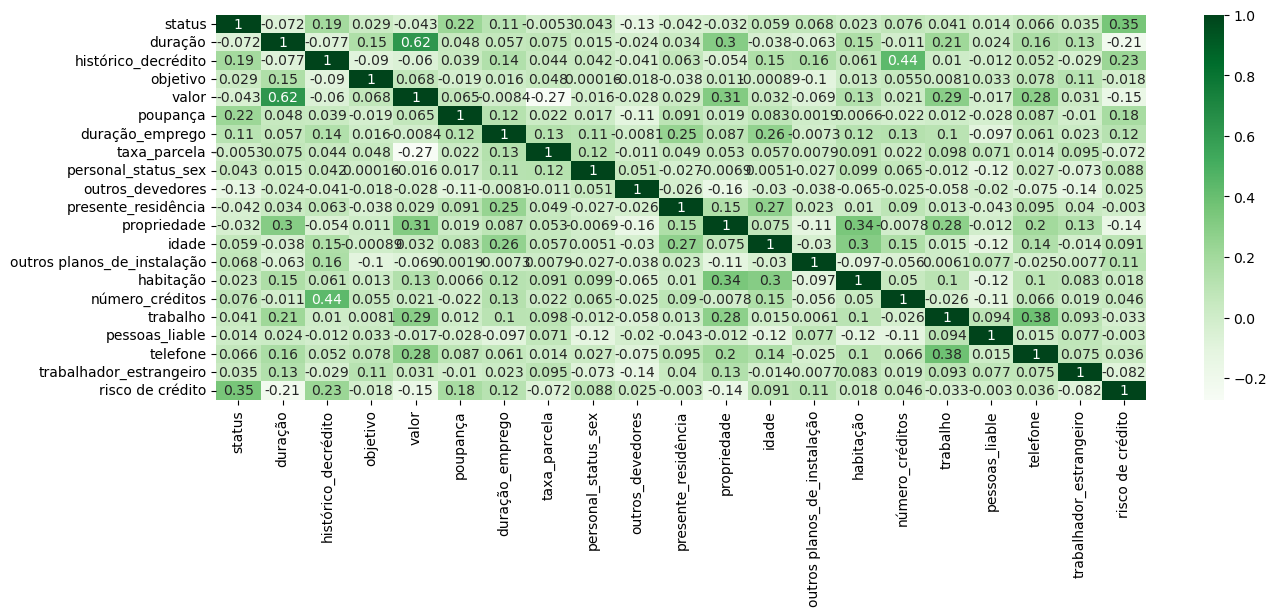

In [9]:
plt.figure(figsize=(15,5))
sns.heatmap(dat.corr(), annot=True, cmap='Greens')
#print(dat.corr())

### Definição de Funções para Análise de Outliers

In [7]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude
def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)   
def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.distplot(coluna, hist=True)
def grafico_barra(coluna):  
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### Analise de features quantitativos
- duração

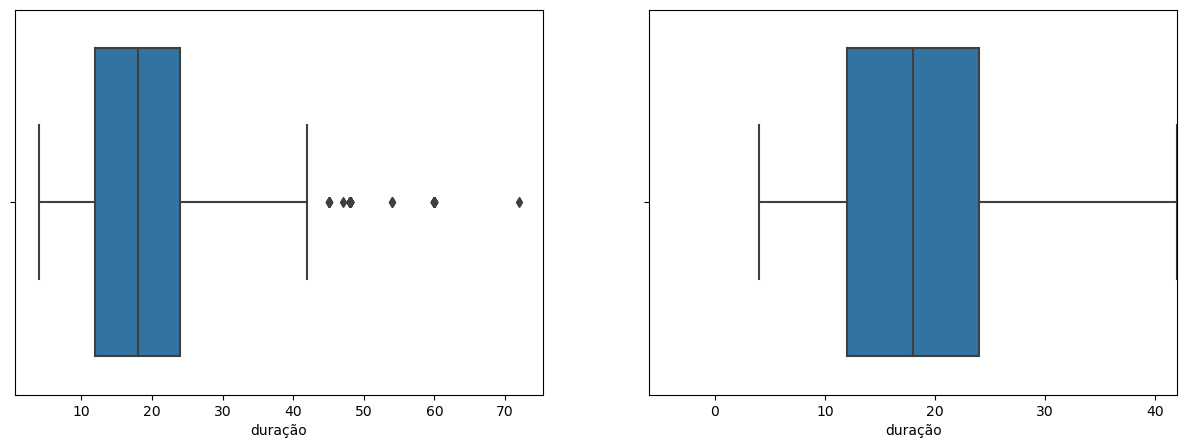

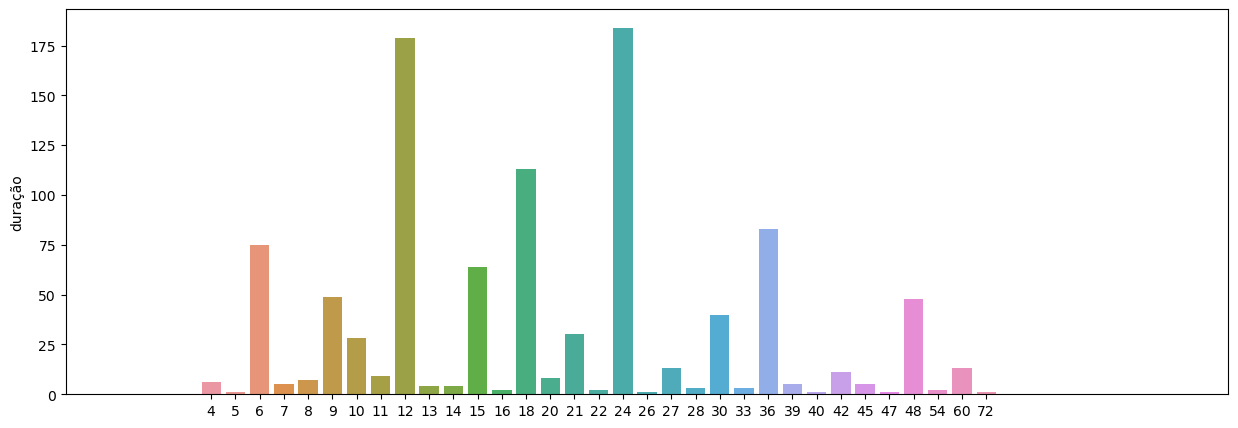

In [169]:
diagrama_caixa(dat['duração'])
grafico_barra(dat['duração'])

A feature duração presenta algumos outliers, mas como a variavel não presenta uma forte influencia sobre a variavel de risco de crédito segum o mapa de calor, decidi não eliminar os outliers para não reducir la muestra de dados que já é pequena (1000 clientes) 

- valor 

C:\Users\Aramary\AppData\Local\Temp\ipykernel_11984\2407182471.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dat['valor'], hist=True)


<Axes: xlabel='valor', ylabel='Density'>

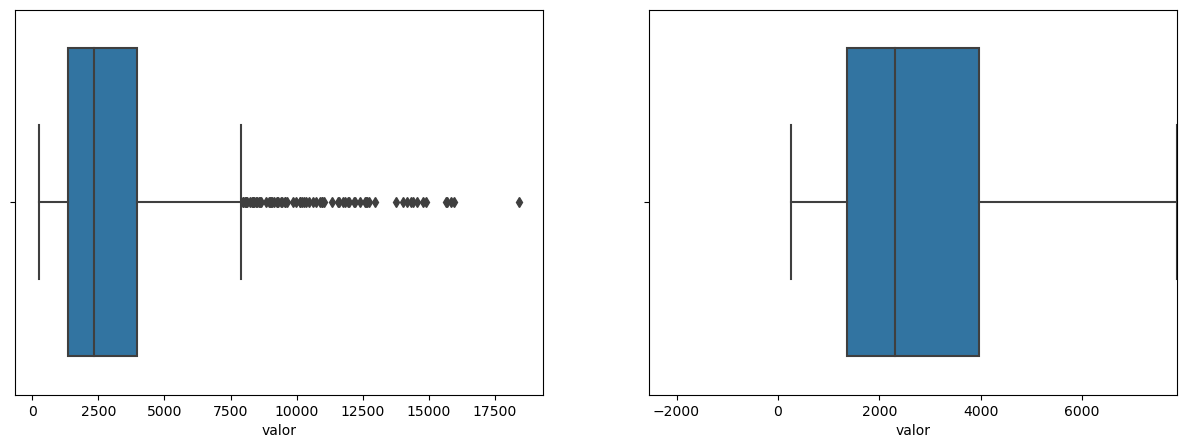

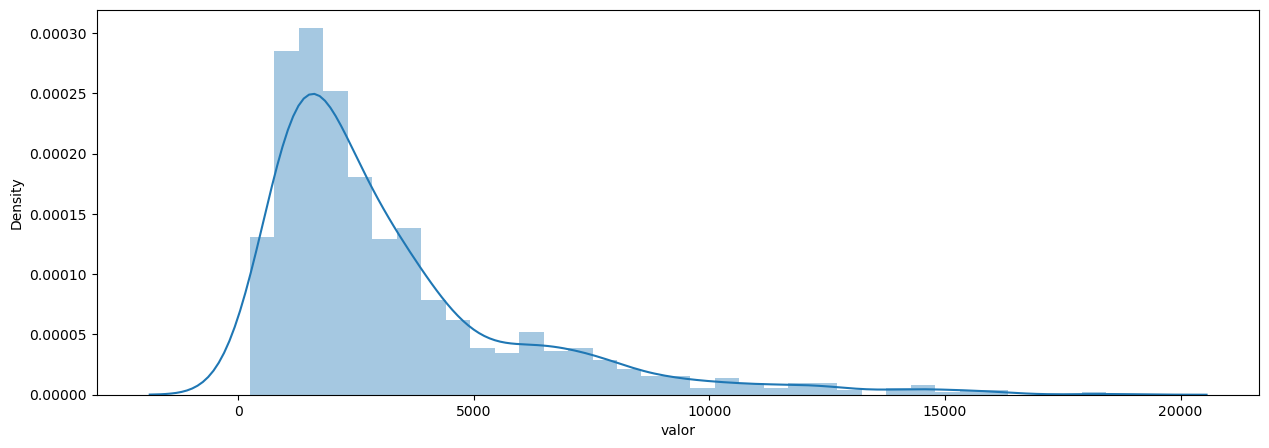

In [176]:
diagrama_caixa(dat['valor'])
plt.figure(figsize=(15, 5))
sns.distplot(dat['valor'], hist=True)

A feature valor presenta outliers, mas como a variavel não presenta uma forte influencia sobre a variavel de risco de crédito segum o mapa de calor, decidi não eliminar os outliers para não reducir la muestra de dados que já é pequena (1000 clientes) 

- idade

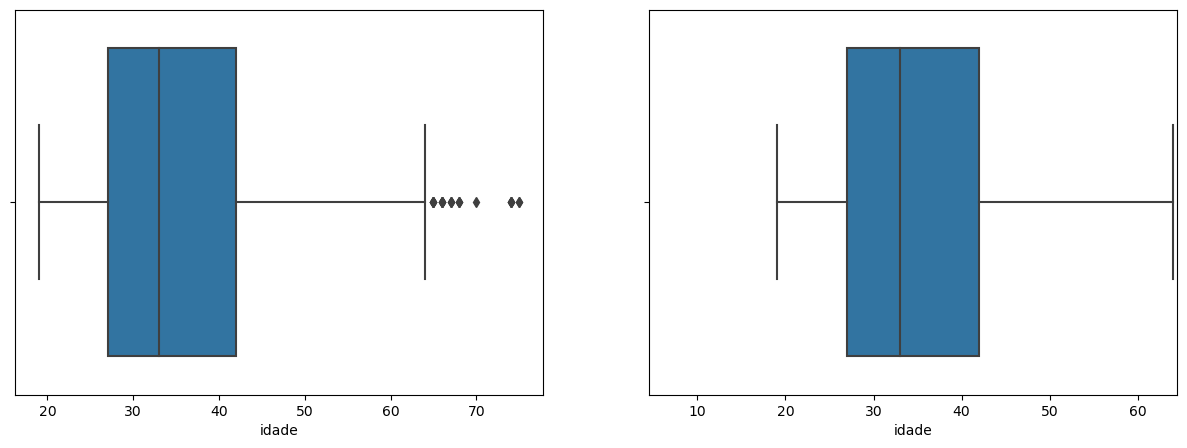

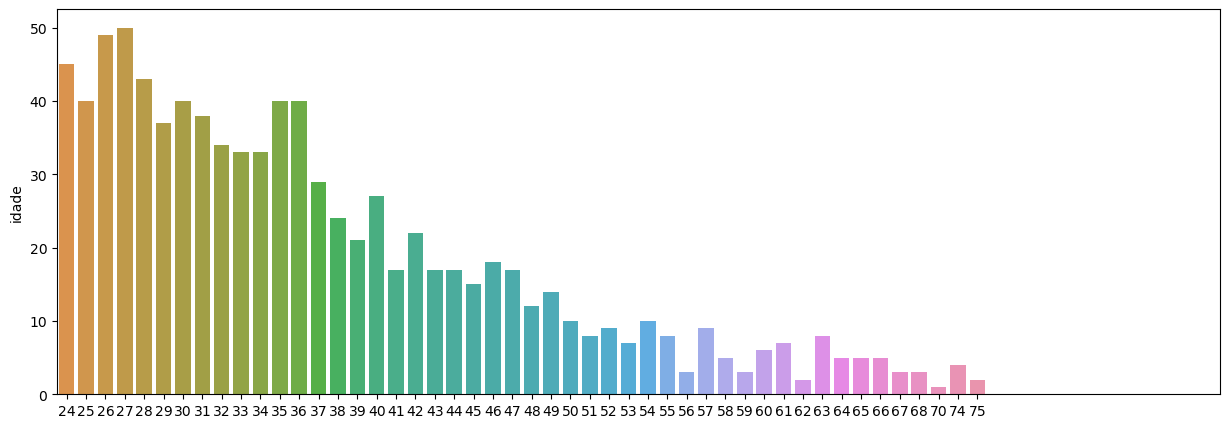

In [178]:
diagrama_caixa(dat['idade'])
grafico_barra(dat['idade'])

A feature idade presenta algumos outliers, mas como a variavel não presenta uma forte influencia sobre a variavel de risco de crédito segum o mapa de calor, decidi não eliminar os outliers para não reducir la muestra de dados que já é pequena (1000 clientes) 

### Analise de features quantitativos discretizados
São quantitativos nos dados, mas na verdade são pontuações discretizadas para uma variável quantitativa subjacente e são, portanto, armazenados como fatores ordenados abaixo

- status da conta corrente

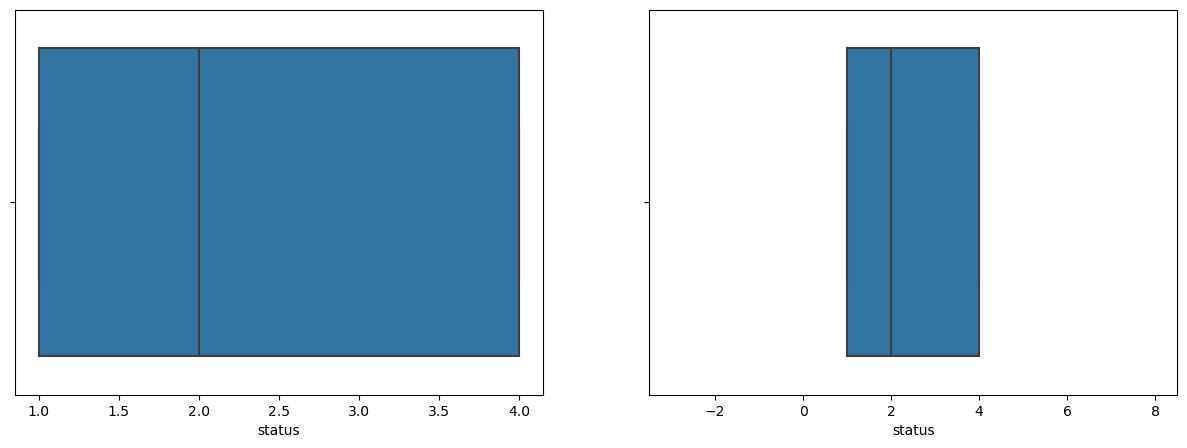

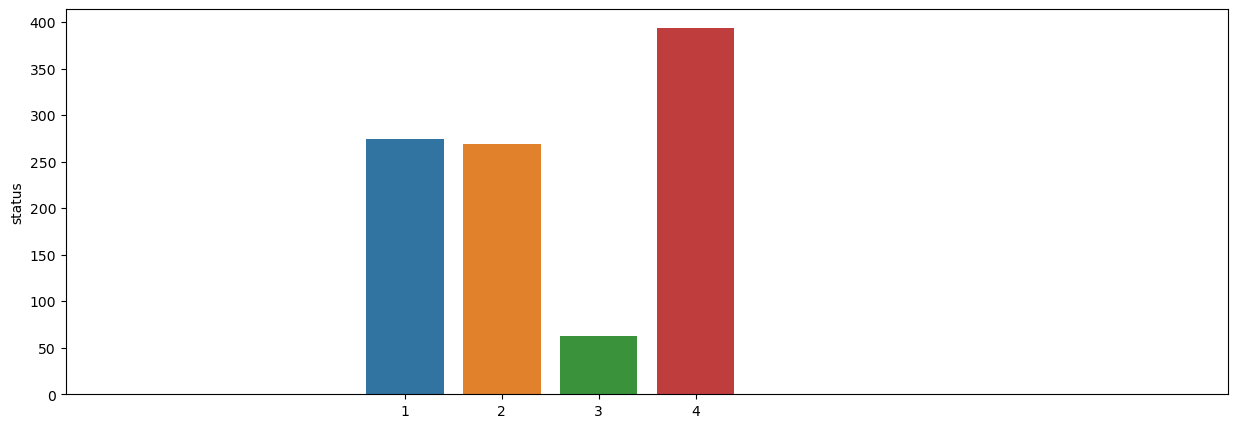

In [8]:
diagrama_caixa(dat['status'])
grafico_barra(dat['status'])

Não presenta outliers
- 1: sem conta corrente
- 2: ... <0 DM
- 3: 0<= ... <200 DM
- 4: ... >= 200 DM/salário por pelo menos 1 ano

- histórico_decrédito

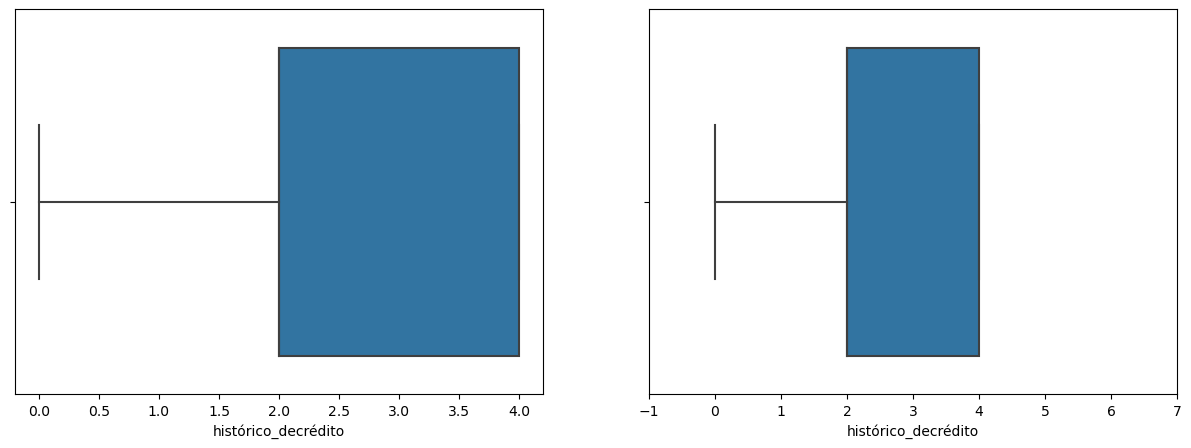

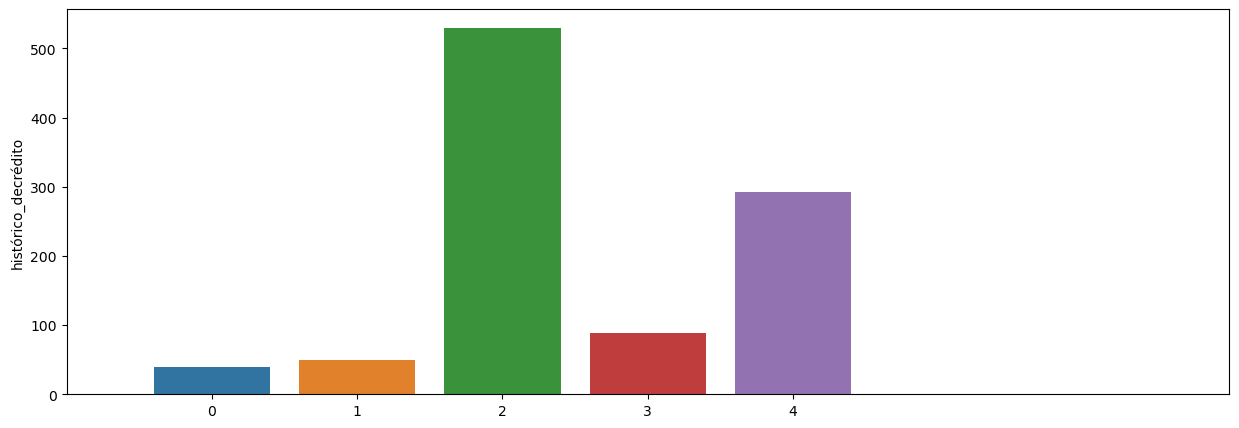

In [9]:
diagrama_caixa(dat['histórico_decrédito'])
grafico_barra(dat['histórico_decrédito'])

Não presenta outliers

A maior cantidad dos clientes tem un historico de credito com nenhum crédito obtido/todos os créditos pagos devidamente 

- poupança 

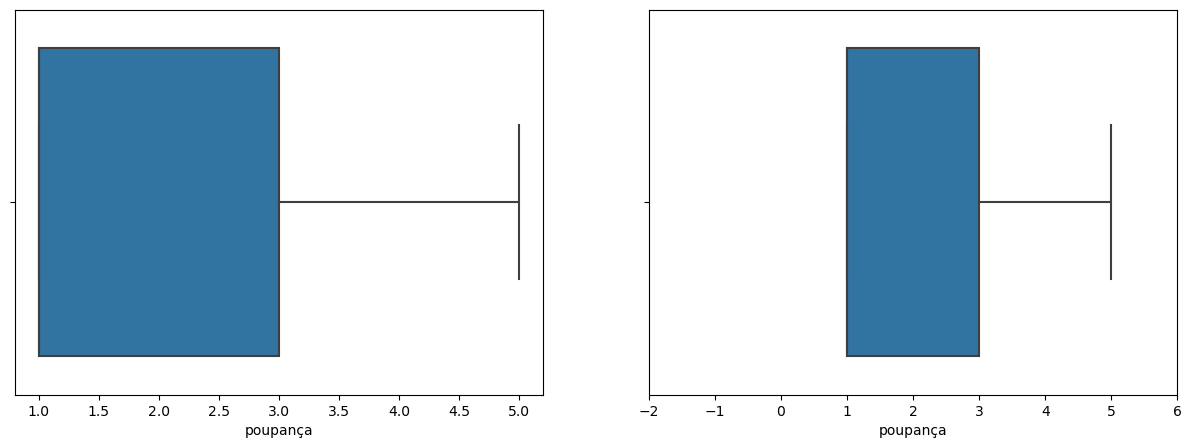

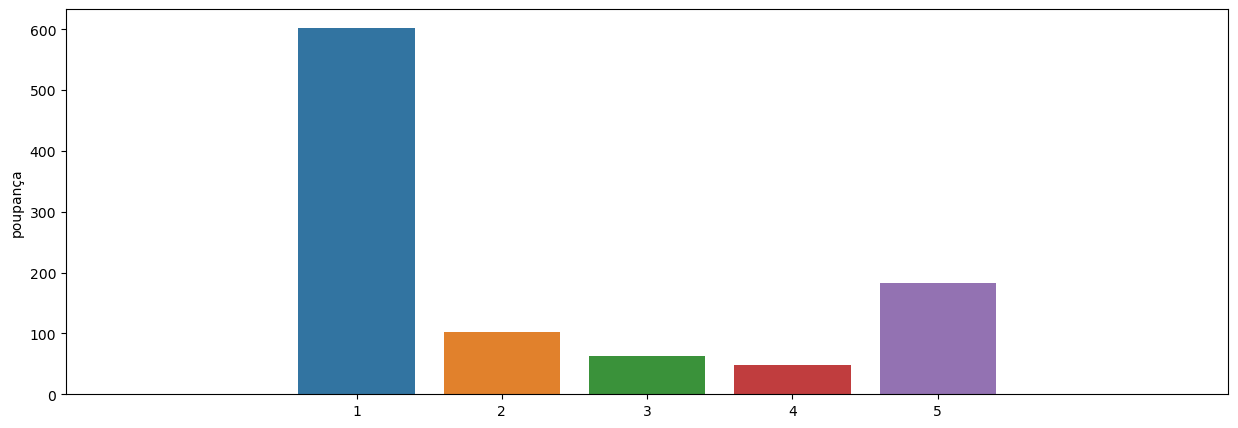

In [10]:
diagrama_caixa(dat['poupança'])
grafico_barra(dat['poupança'])

Não presenta outliers

- 1: desconhecido/sem conta poupança
- 2: ... <100 DM
- 3: 100 <= ... <500 DM
- 4: 500 <= ... < 1000 DM
- 5: ... >= 1000 DM

A maioria dos clientes não tem conta poupança ou poupam poco

- duração_emprego

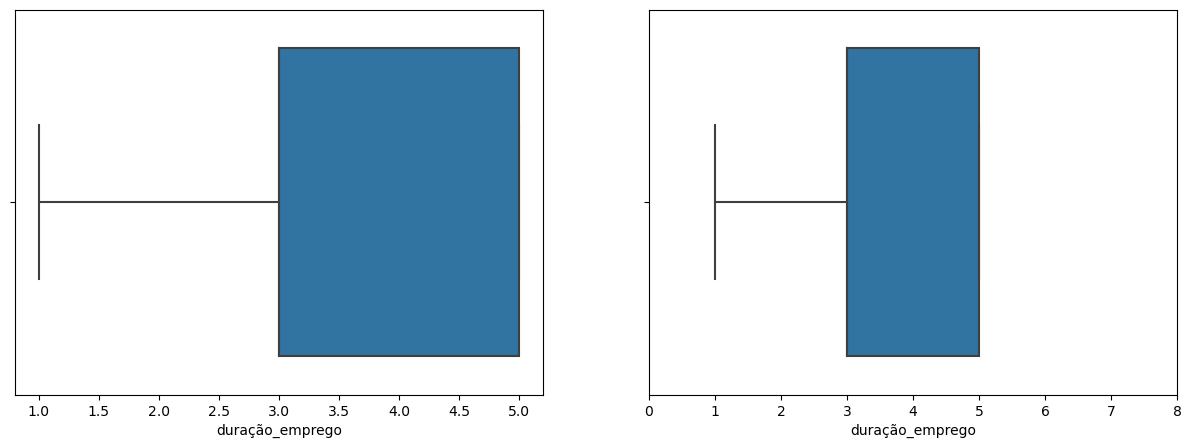

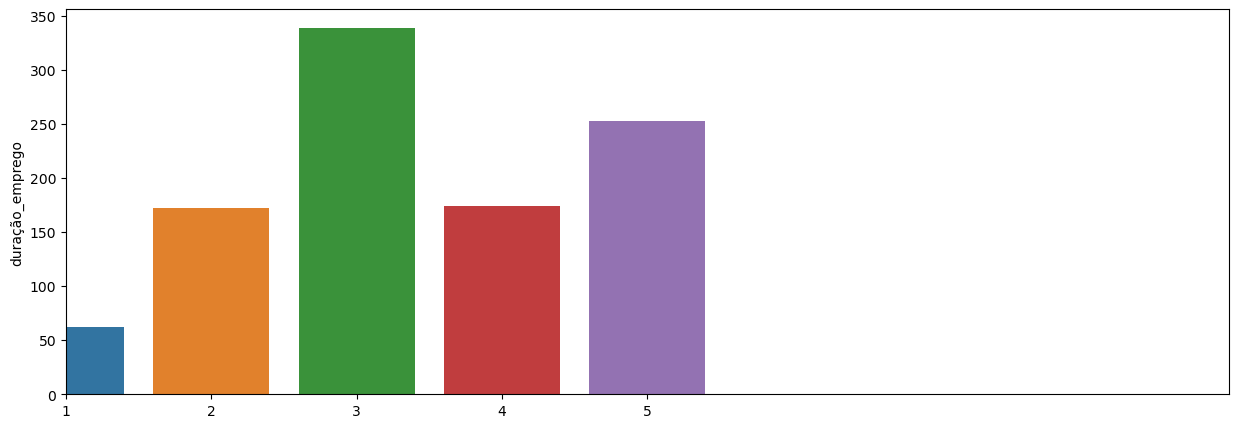

In [11]:
diagrama_caixa(dat['duração_emprego'])
grafico_barra(dat['duração_emprego'])

Não tem outliers

A maioria dos clientes tem uma duração de emprego de 3 a 5 anos com o empregador actual

- objetivo

C:\Users\Aramary\AppData\Local\Temp\ipykernel_6620\2629023580.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dat['objetivo'], hist=True)


<Axes: xlabel='objetivo', ylabel='Density'>

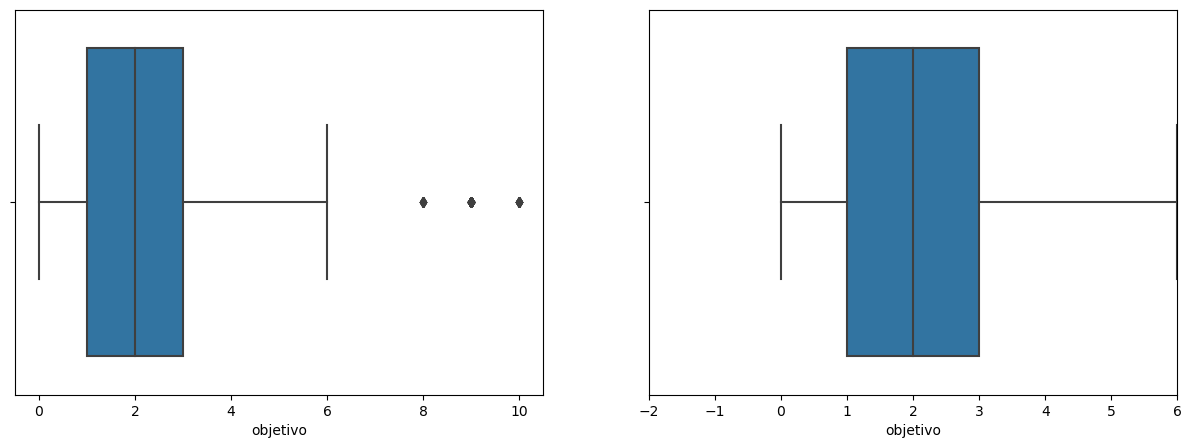

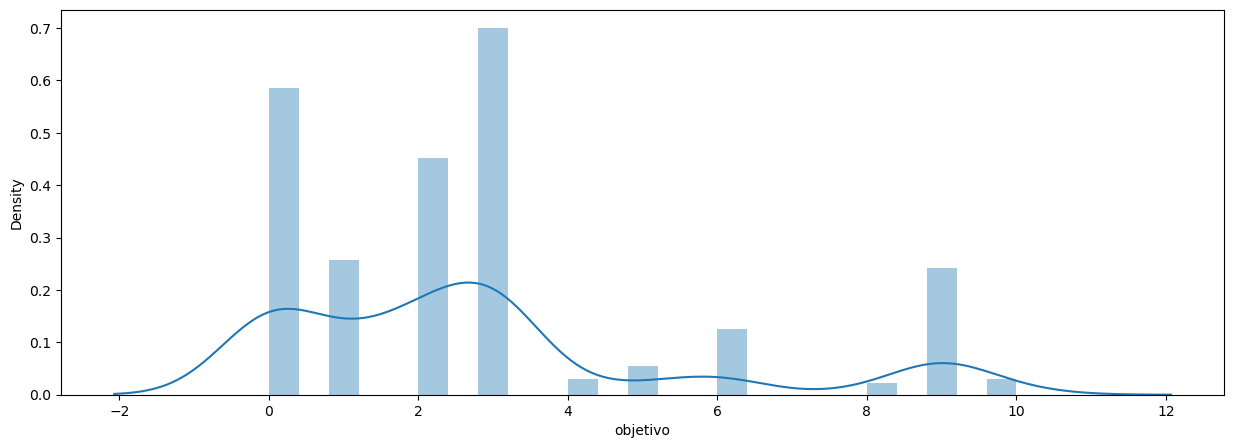

In [12]:
#diagrama_caixa(dat['objetivo'])
#grafico_barra(dat['objetivo'])
diagrama_caixa(dat['objetivo'])
plt.figure(figsize=(15, 5))
sns.distplot(dat['objetivo'], hist=True)

A categoria objetivos presenta algumos outliers que podem ser eliminados

A tendencia dos clientes é solicitar credito para compra de carro (novo), carro (usado), móveis/equipamentos) e férias

- taxa_parcela respeto ao salario do cliente

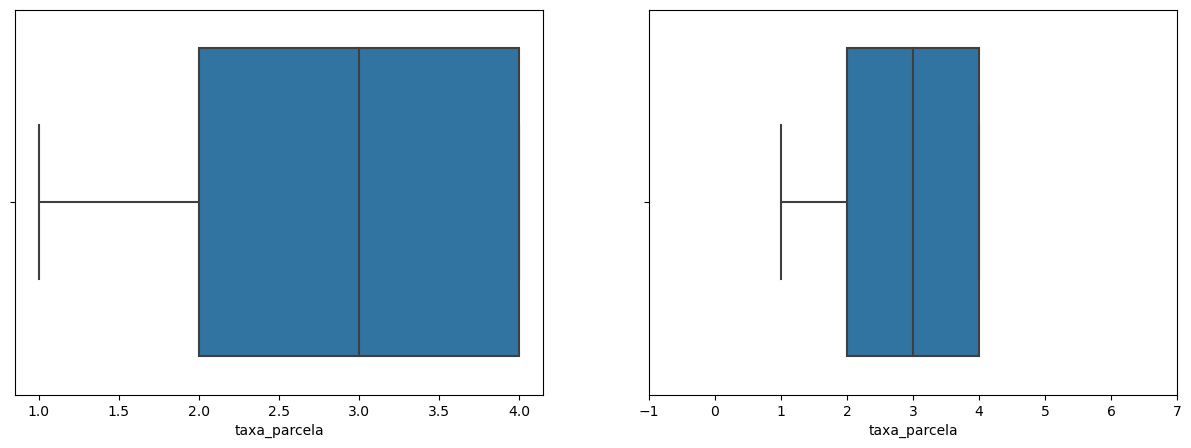

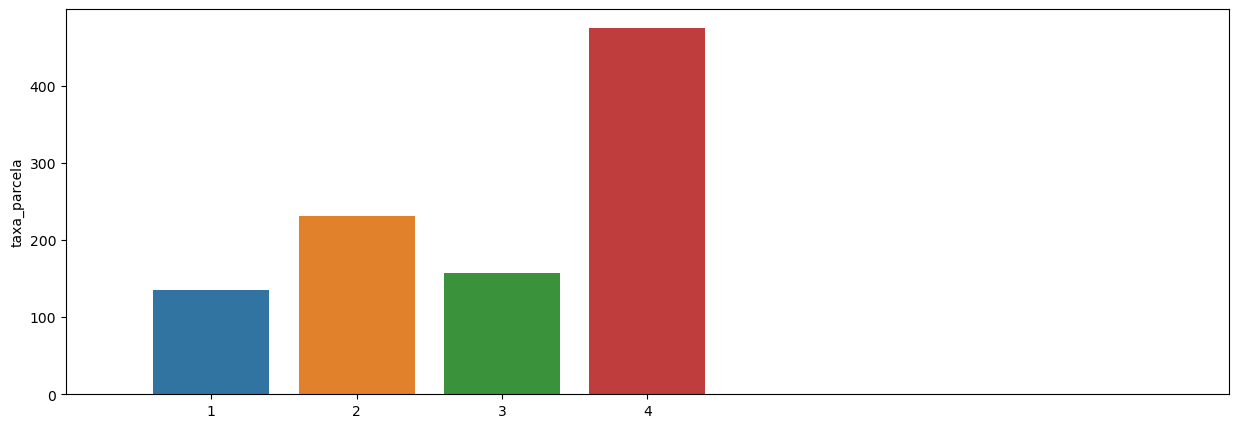

In [13]:
diagrama_caixa(dat['taxa_parcela'])
grafico_barra(dat['taxa_parcela'])

Não presenta outliers

O clientes preferem parcelas que representan um valor abaixo do 35% de seu salario e a maioria tem parcelas abaixo do 20%

- presente_residência

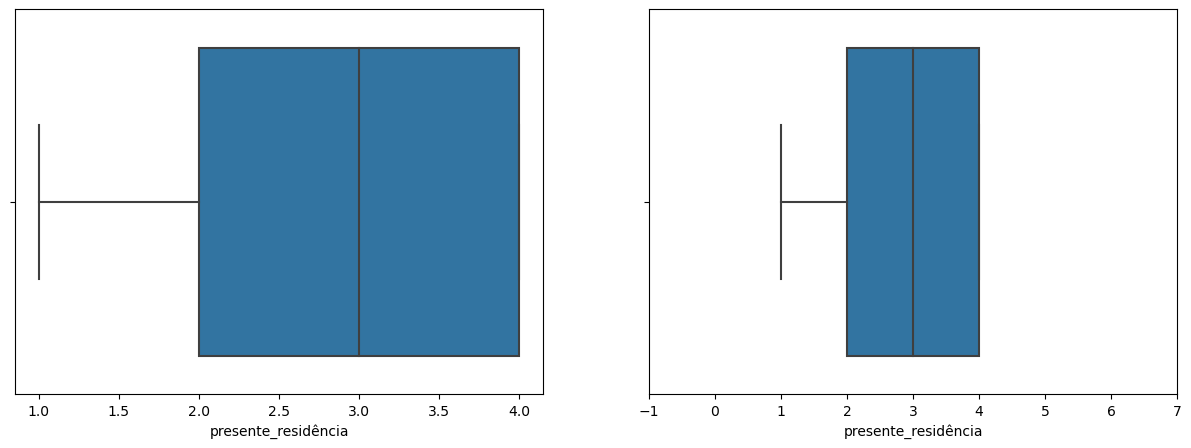

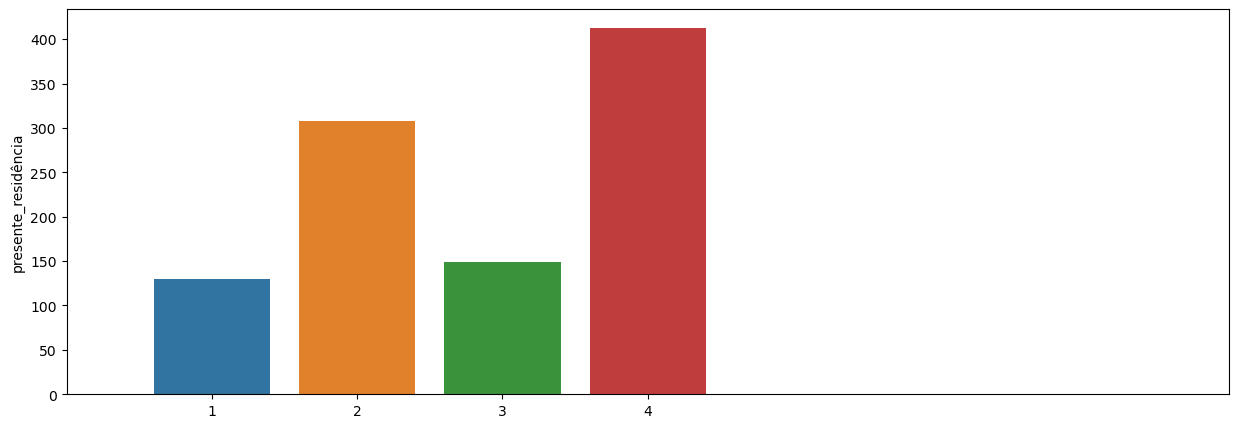

In [14]:
diagrama_caixa(dat['presente_residência'])
grafico_barra(dat['presente_residência'])

Não presenta outliers

A media de moradia na mesma casa é 1 a 7 anos, onde a gran maioria dos clientes moran faz mais de 7 anos na mesma casa

- número_crédito

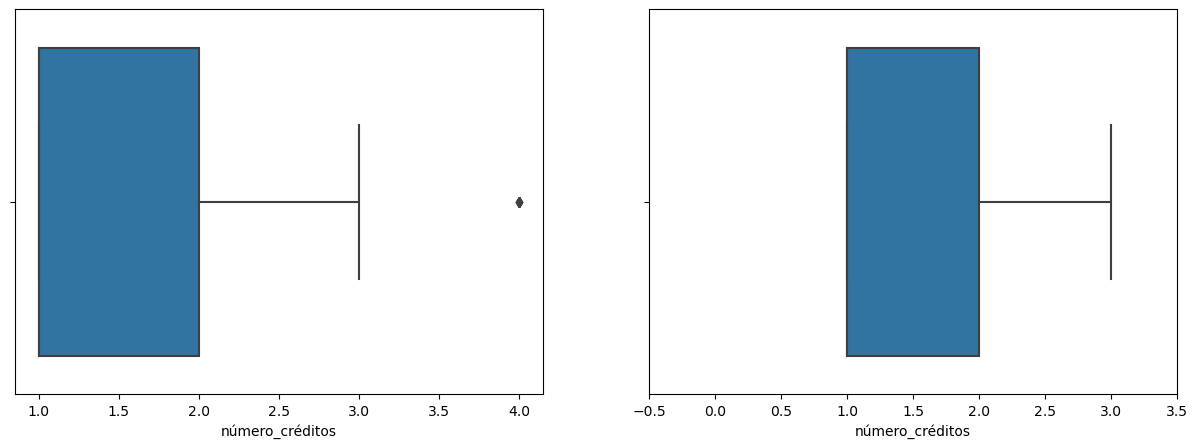

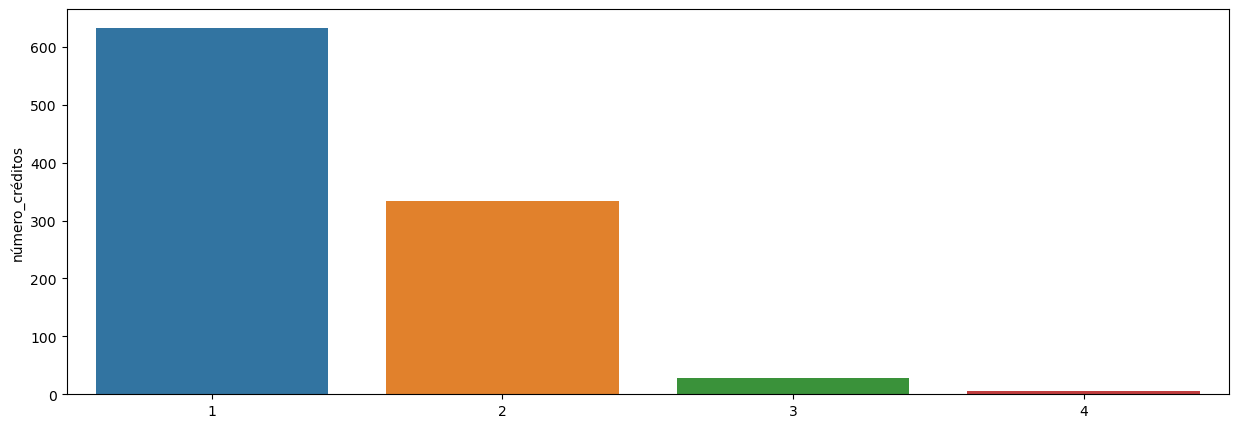

In [15]:
diagrama_caixa(dat['número_créditos'])
grafico_barra(dat['número_créditos'])

Las categorias 3 e 4 da feature número_crédito son despreciables en comparação com a categoria 1 e 2, por lo que podem ser agrupadas em uma sola categoria

A maioria dos clientes tem solicitados de 1 a 3 creditos, incluyendo o credito solicitado neste banco e tambem em outros bancos

- personal_status_sex

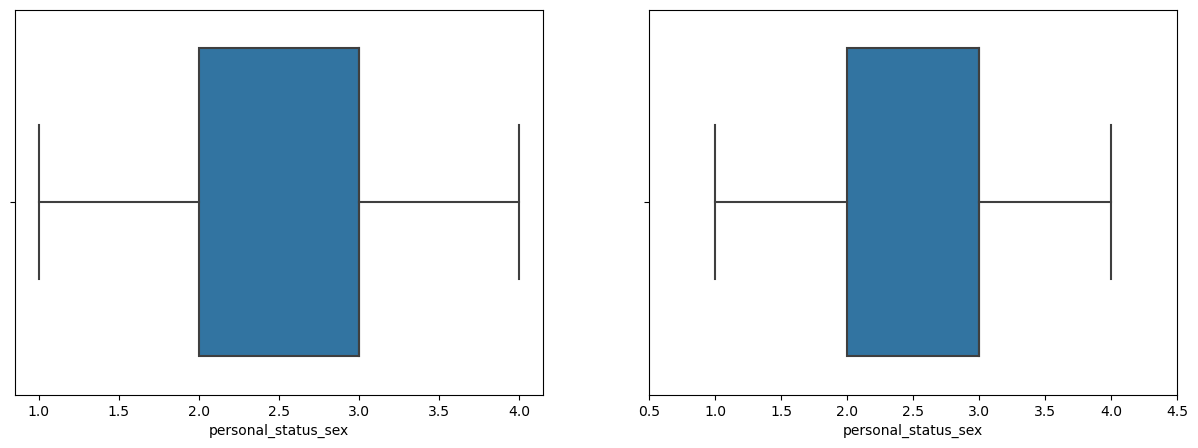

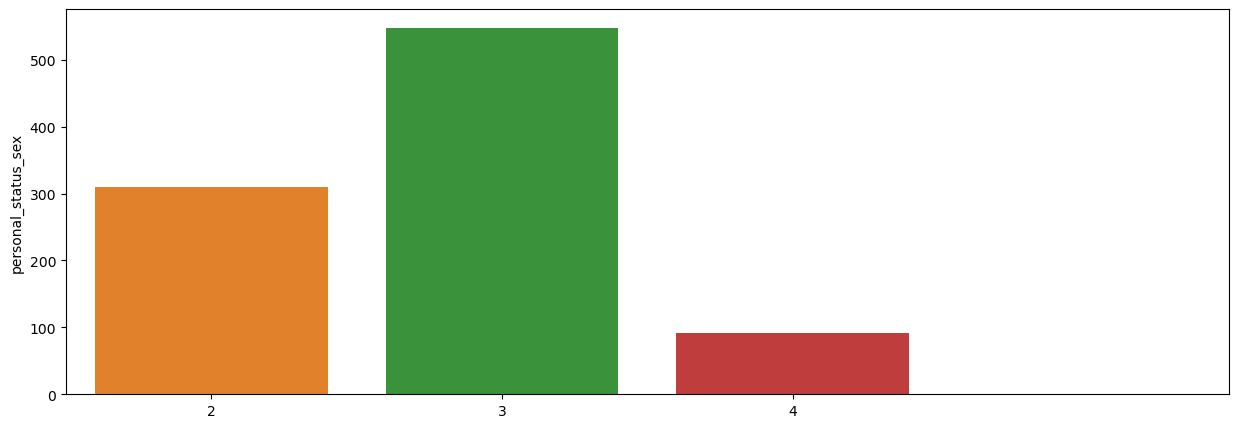

In [6]:
diagrama_caixa(dat['personal_status_sex'])
grafico_barra(dat['personal_status_sex'])

'status_pessoal_sexo' : Informações combinadas sobre sexo e estado civil; categórico; o sexo não pode ser recuperado da variável, pois homens solteiros e mulheres não solteiras são codificados com o mesmo código (2); as viúvas femininas não podem ser facilmente classificadas, porque a tabela de códigos não as lista em nenhuma das categorias femininas

- 1: masculino: divorciado/separado
- 2: feminino: não solteiro ou masculino: solteiro
- 3: masculino: casado/viúvo
- 4: feminino: solteiro

Como hay categorias que presentan problemas de classificação ou não podem ser facilmente classificadas e tem a categoria 1 (masculino: divorciado/separado), que não presenta uma muestra de clientes, pode inducir problemos em nosso modelo alem de que segum o mapa de correlação esta feature não presenta uma influença significativa para a variavel de saida. Então decidi eliminar essa categoria

In [16]:
dat=dat.drop(['personal_status_sex'], axis=1)
dat.shape

(1000, 20)

- outros_devedores

C:\Users\Aramary\AppData\Local\Temp\ipykernel_6620\2657817359.py:16: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\Aramary\AppData\Local\Temp\ipykernel_6620\2657817359.py:24: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(limites(coluna))
C:\Users\Aramary\AppData\Local\Temp\ipykernel_6620\3441680887.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dat['outros_devedores'], hist=True)


<Axes: xlabel='outros_devedores', ylabel='Density'>

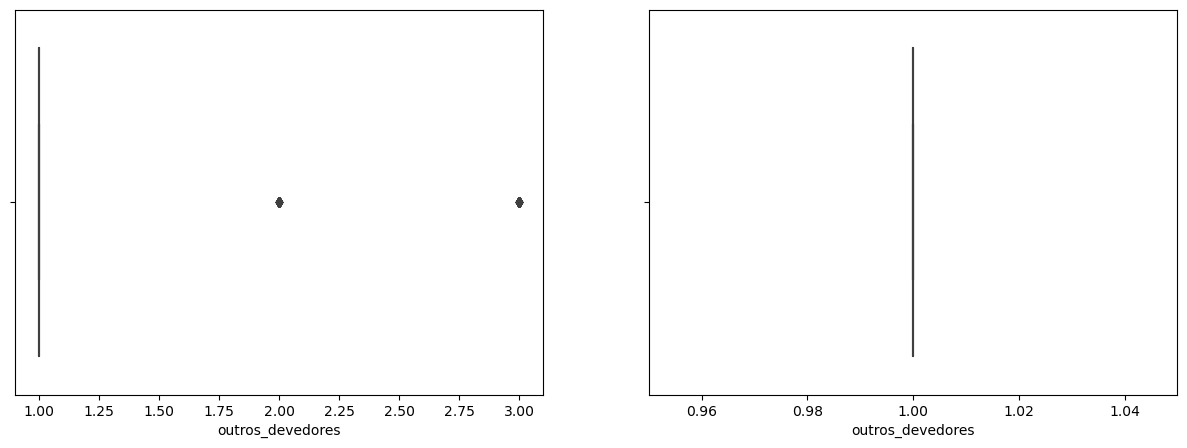

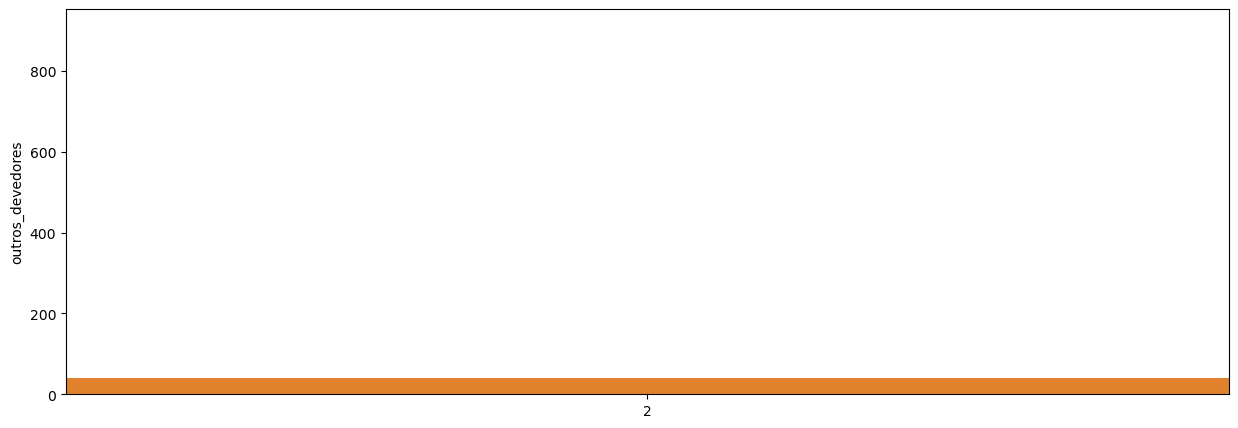

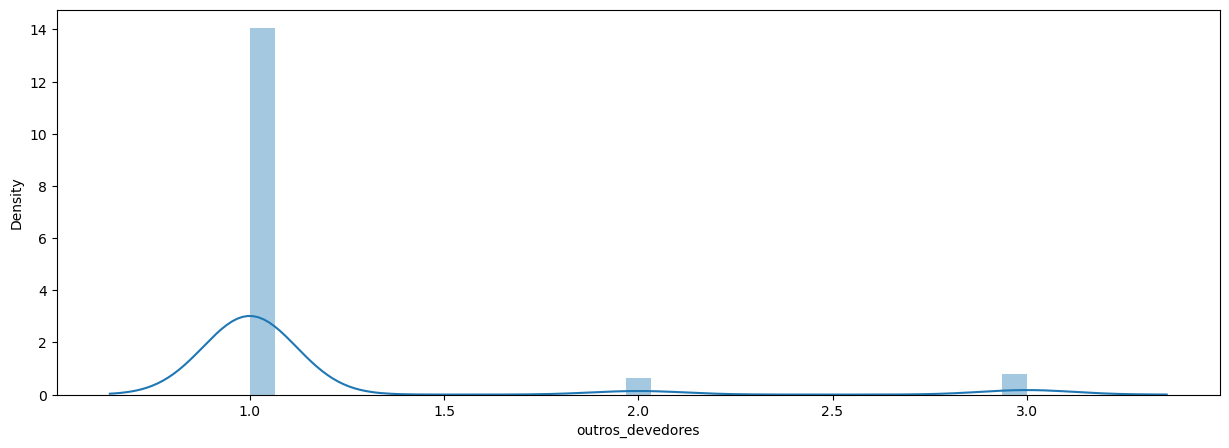

In [17]:
diagrama_caixa(dat['outros_devedores'])
grafico_barra(dat['outros_devedores'])
plt.figure(figsize=(15, 5))
sns.distplot(dat['outros_devedores'], hist=True)

In [18]:
print(dat['outros_devedores'].value_counts())

1    907
3     52
2     41
Name: outros_devedores, dtype: int64


- propriedade

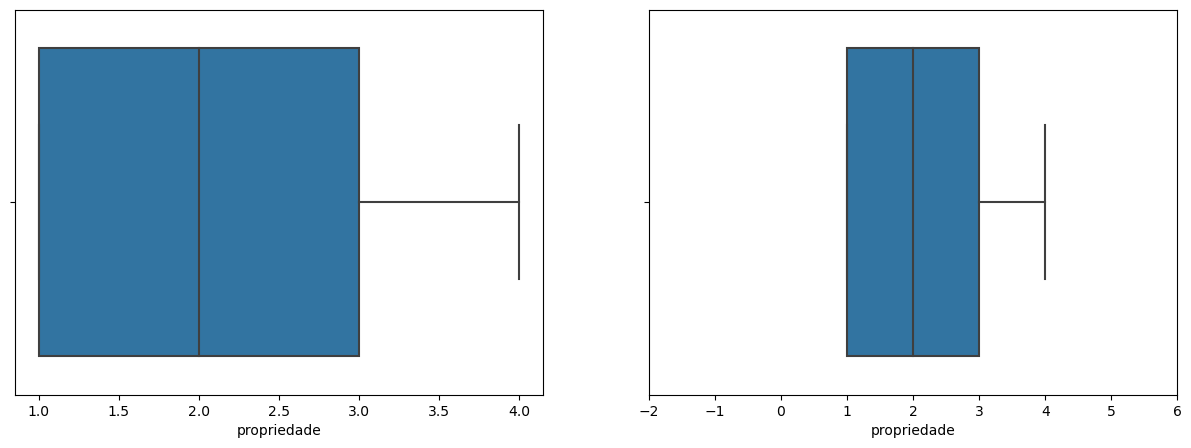

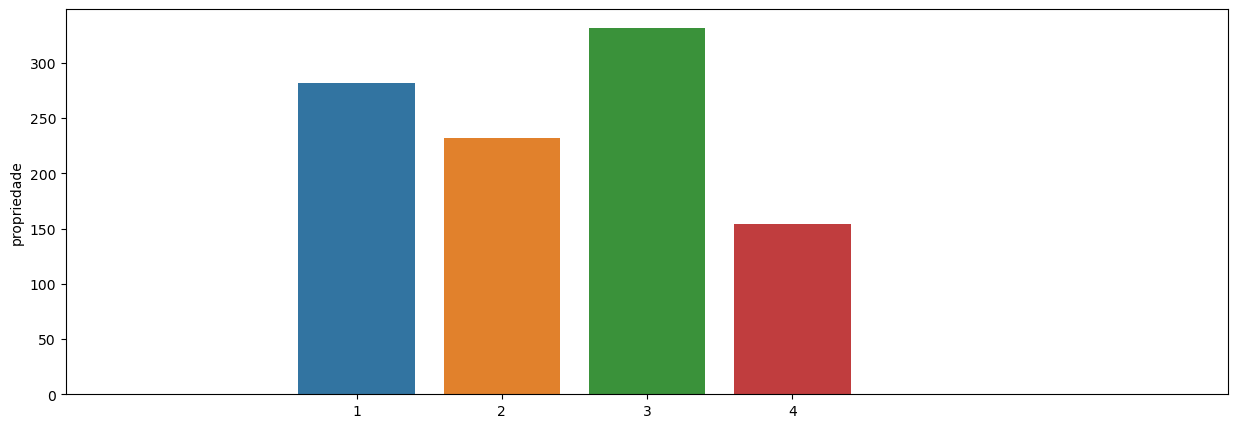

In [19]:
diagrama_caixa(dat['propriedade'])
grafico_barra(dat['propriedade'])

- outros planos_de_instalação

C:\Users\Aramary\AppData\Local\Temp\ipykernel_6620\2657817359.py:16: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\Aramary\AppData\Local\Temp\ipykernel_6620\3436793979.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dat['outros planos_de_instalação'], hist=True)


3    814
1    139
2     47
Name: outros planos_de_instalação, dtype: int64

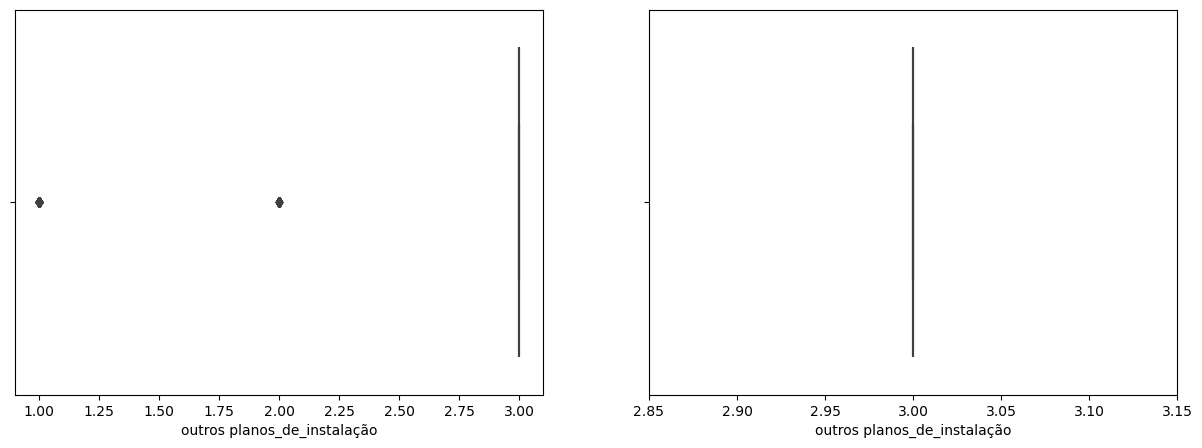

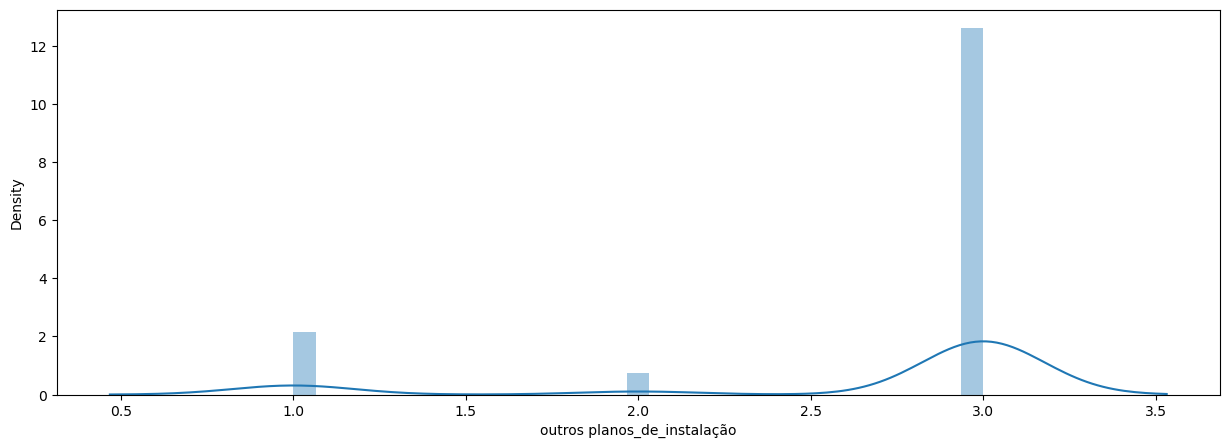

In [20]:
diagrama_caixa(dat['outros planos_de_instalação'])
#grafico_barra(dat['outros planos_de_instalação'])
plt.figure(figsize=(15, 5))
sns.distplot(dat['outros planos_de_instalação'], hist=True)
dat['outros planos_de_instalação'].value_counts()

- habitação

C:\Users\Aramary\AppData\Local\Temp\ipykernel_10888\3218554050.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dat['habitação'], hist=True)


2    714
1    179
3    107
Name: habitação, dtype: int64

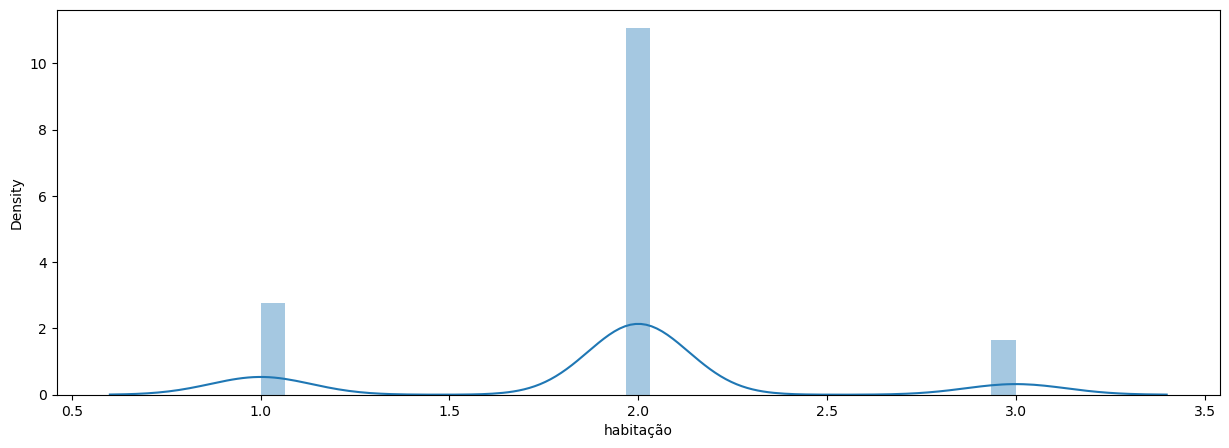

In [17]:
plt.figure(figsize=(15, 5))
sns.distplot(dat['habitação'], hist=True)
dat['habitação'].value_counts()

- trabalho

C:\Users\Aramary\AppData\Local\Temp\ipykernel_6620\2657817359.py:16: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\Aramary\AppData\Local\Temp\ipykernel_6620\71067522.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dat['trabalho'], hist=True)


3    630
2    200
4    148
1     22
Name: trabalho, dtype: int64

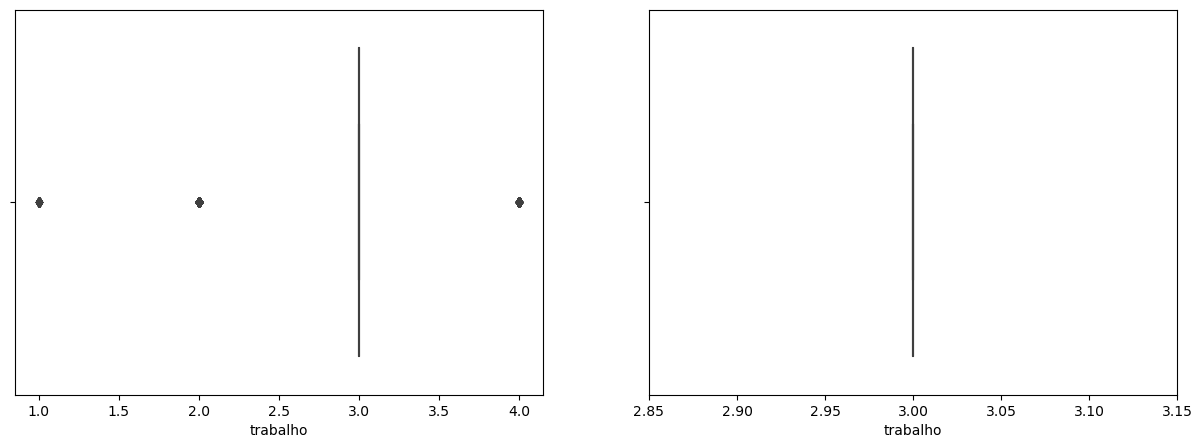

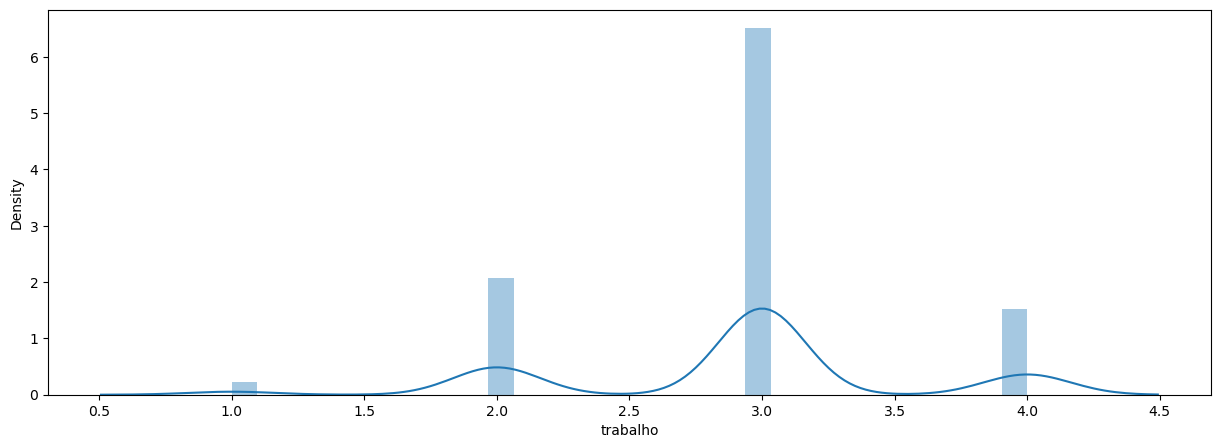

In [21]:
diagrama_caixa(dat['trabalho'])
#grafico_barra(dat['trabalho'])
plt.figure(figsize=(15, 5))
sns.distplot(dat['trabalho'], hist=True)
dat['trabalho'].value_counts()

- pessoas_liable

C:\Users\Aramary\AppData\Local\Temp\ipykernel_6620\2657817359.py:16: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\Aramary\AppData\Local\Temp\ipykernel_6620\4216238786.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dat['pessoas_liable'], hist=True)


2    845
1    155
Name: pessoas_liable, dtype: int64

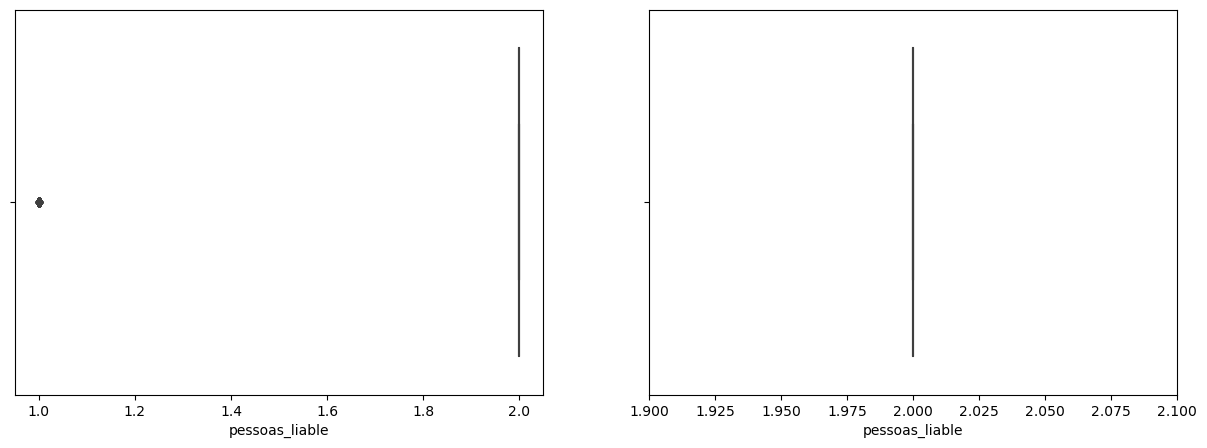

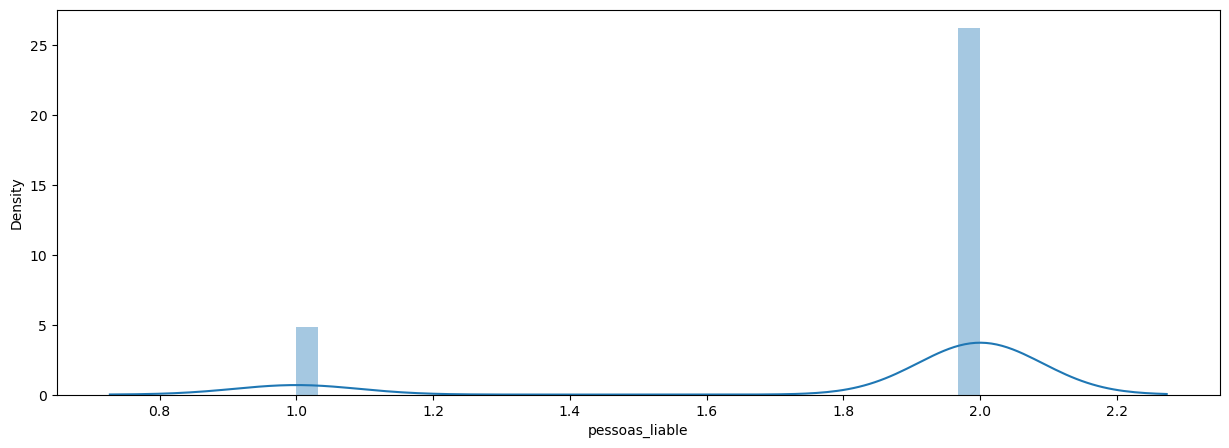

In [22]:
diagrama_caixa(dat['pessoas_liable'])
#grafico_barra(dat['pessoas_liable'])
plt.figure(figsize=(15, 5))
sns.distplot(dat['pessoas_liable'], hist=True)
dat['pessoas_liable'].value_counts()

- telefone

C:\Users\Aramary\AppData\Local\Temp\ipykernel_10888\3572801390.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dat['telefone'], hist=True)


1    596
2    404
Name: telefone, dtype: int64

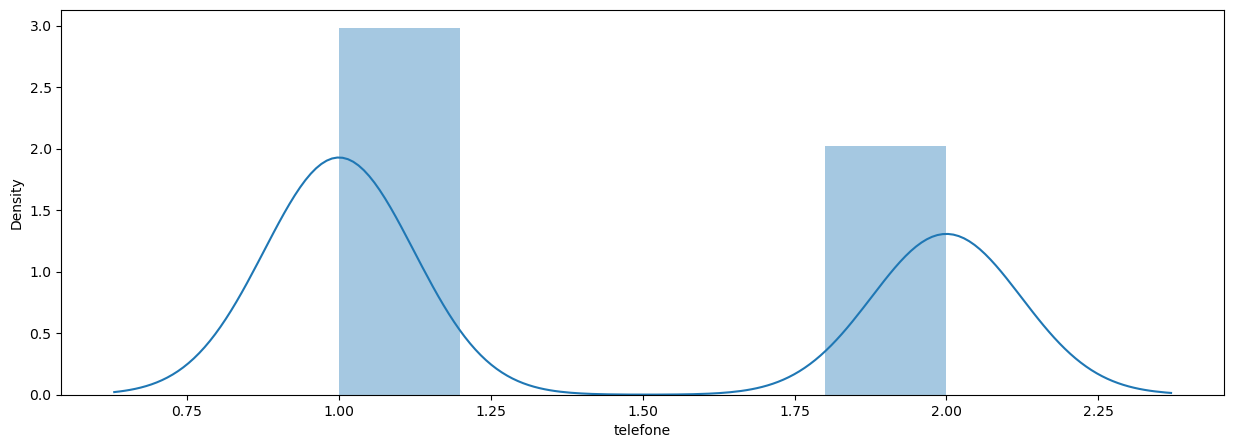

In [22]:
plt.figure(figsize=(15, 5))
sns.distplot(dat['telefone'], hist=True)
dat['telefone'].value_counts()

- trabalhador_estrangeiro

C:\Users\Aramary\AppData\Local\Temp\ipykernel_10888\1692034582.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dat['trabalhador_estrangeiro'], hist=True)


2    963
1     37
Name: trabalhador_estrangeiro, dtype: int64

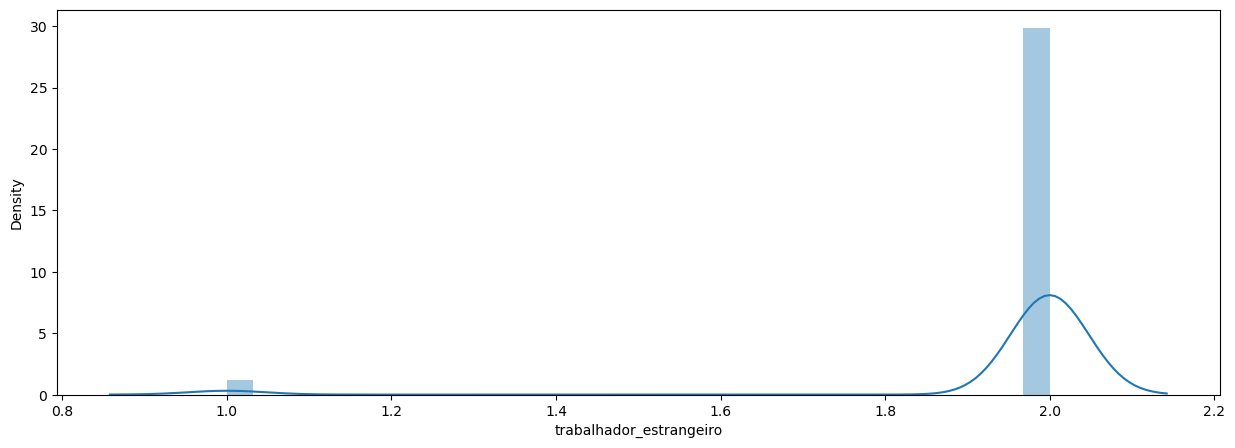

In [23]:
plt.figure(figsize=(15, 5))
sns.distplot(dat['trabalhador_estrangeiro'], hist=True)
dat['trabalhador_estrangeiro'].value_counts()

### Encoding

- Vou a testar trabalhar com a tabela original "dat" que tem colunas categoricas que podem ter  valores de 0 a 4 

- Vou a testar trabalhar com a tabela "dat_cod" que tem as colunas categoricas levadas a variables dummies (transforma cada categoria de una feature em uma nueva columna e codifica con valores de 0 e 1

In [23]:
print(dat.shape)
display(dat.head())

(1000, 20)


,status,duração,histórico_decrédito,objetivo,valor,poupança,duração_emprego,taxa_parcela,outros_devedores,presente_residência,propriedade,idade,outros planos_de_instalação,habitação,número_créditos,trabalho,pessoas_liable,telefone,trabalhador_estrangeiro,risco de crédito
1,1,18,4,2,1049,1,2,4,1,4,2,21,3,1,1,3,2,1,2,1
2,1,9,4,0,2799,1,3,2,1,2,1,36,3,1,2,3,1,1,2,1
3,2,12,2,9,841,2,4,2,1,4,1,23,3,1,1,2,2,1,2,1
4,1,12,4,0,2122,1,3,3,1,2,1,39,3,1,2,2,1,1,1,1
5,1,12,4,0,2171,1,3,4,1,4,2,38,1,2,2,2,2,1,1,1


In [24]:
dat_cod=dat.copy()
columnas_categoricas=['status', 'histórico_decrédito', 'objetivo',
       'poupança', 'duração_emprego', 'taxa_parcela',
       'outros_devedores', 'presente_residência', 'propriedade',
       'outros planos_de_instalação', 'habitação', 'número_créditos',
       'trabalho', 'pessoas_liable', 'telefone', 'trabalhador_estrangeiro']
dat_cod=pd.get_dummies(data=dat_cod, columns=columnas_categoricas)
print(dat_cod.shape)
display(dat_cod.head())

(1000, 68)


,duração,valor,idade,risco de crédito,status_1,status_2,status_3,status_4,histórico_decrédito_0,histórico_decrédito_1,...,trabalho_1,trabalho_2,trabalho_3,trabalho_4,pessoas_liable_1,pessoas_liable_2,telefone_1,telefone_2,trabalhador_estrangeiro_1,trabalhador_estrangeiro_2
1,18,1049,21,1,1,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
2,9,2799,36,1,1,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,1
3,12,841,23,1,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
4,12,2122,39,1,1,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0
5,12,2171,38,1,1,0,0,0,0,0,...,0,1,0,0,0,1,1,0,1,0


### Criação do Modelo com a tabela "dat_cod"

#### Criar variaveis de features e variavel de saída

- X- Vetor de feature

- Y- Vetor de saída

In [14]:
X = dat_cod.drop(columns=['risco de crédito'],axis=1)
Y = dat_cod['risco de crédito']

#### Separar em conjuntos de treinamento e teste

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y, random_state=2)

### Modelo SVM

#### Carregar o modelo

In [16]:
classificador = svm.SVC(kernel='linear')

#### Treinar modelo

In [17]:
classificador.fit(X_train,Y_train)

SVC(kernel='linear')

#### Avaliar Resultados

In [18]:
X_train_prediction = classificador.predict(X_train)
acc_xy_train = accuracy_score(X_train_prediction, Y_train)
print('Assertividade no conjunto de treinamento: ', acc_xy_train)

Assertividade no conjunto de treinamento:  0.7811111111111111


In [19]:
X_test_prediction = classificador.predict(X_test)
acc_xy_test = accuracy_score(X_test_prediction, Y_test)
print('Assertividade no conjunto de teste: ', acc_xy_test)

Assertividade no conjunto de teste:  0.79


In [22]:
pred_proba = classificador.predict(X_train)
fpr, tpr, thresholds = roc_curve(list(Y_train), list(pred_proba), pos_label=1)
print('AUC no conjunto de treinamento (SVM): ', auc(fpr, tpr))

pred_proba = classificador.predict(X_test)
fpr, tpr, thresholds = roc_curve(list(Y_test), list(pred_proba), pos_label=1)
print('AUC no conjunto de teste (SVM): ', auc(fpr, tpr))

AUC no conjunto de treinamento (SVM):  0.6902116402116402
AUC no conjunto de teste (SVM):  0.6880952380952381


### Criação do Modelo com a tabela "dat"

In [50]:
X = dat.drop(columns=['risco de crédito'],axis=1)
Y = dat['risco de crédito']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y, random_state=2)

classificador = svm.SVC(kernel='linear')

classificador.fit(X_train,Y_train)

X_train_prediction = classificador.predict(X_train)
acc_xy_train = accuracy_score(X_train_prediction, Y_train)
print('Assertividade no conjunto de treinamento: ', acc_xy_train)

X_test_prediction = classificador.predict(X_test)
acc_xy_test = accuracy_score(X_test_prediction, Y_test)
print('Assertividade no conjunto de teste: ', acc_xy_test)

Assertividade no conjunto de treinamento:  0.7577777777777778
Assertividade no conjunto de teste:  0.75


- Como os melhores resultados são do modelo criado com a tabela "dat_cod", que é a que presenta um encoding com variables dummies, então essa tabela é a que vai ser usada para a criação dos nossos modelos 

### Modelo DecisionTreeClassifier

In [23]:
X = dat_cod.drop(columns=['risco de crédito'],axis=1)
Y = dat_cod['risco de crédito']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y, random_state=2)

In [24]:
classificador = tree.DecisionTreeClassifier()
classificador.fit(X_train,Y_train)

DecisionTreeClassifier()

In [26]:
X_train_prediction = classificador.predict(X_train)
acc_xy_train = accuracy_score(X_train_prediction, Y_train)
print('Assertividade no conjunto de treinamento: ', acc_xy_train)

X_test_prediction = classificador.predict(X_test)
acc_xy_test = accuracy_score(X_test_prediction, Y_test)
print('Assertividade no conjunto de teste: ', acc_xy_test)

pred_proba = classificador.predict(X_train)
fpr, tpr, thresholds = roc_curve(list(Y_train), list(pred_proba), pos_label=1)
print('AUC no conjunto de treinamento (DecisionTreeClassifier): ', auc(fpr, tpr))

pred_proba = classificador.predict(X_test)
fpr, tpr, thresholds = roc_curve(list(Y_test), list(pred_proba), pos_label=1)
print('AUC no conjunto de teste (DecisionTreeClassifier): ', auc(fpr, tpr))

Assertividade no conjunto de treinamento:  1.0
Assertividade no conjunto de teste:  0.73
AUC no conjunto de treinamento (DecisionTreeClassifier):  1.0
AUC no conjunto de teste (DecisionTreeClassifier):  0.7119047619047619


In [ ]:
import graphviz

dot_data = tree.export_graphviz(classificador, out_file=None,
                     feature_names=list(X.columns),
                     class_names=Y.unique().tolist(),
                     filled=True, rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)
graph

### Modelo LogisticRegression

In [27]:
X = dat_cod.drop(columns=['risco de crédito'],axis=1)
Y = dat_cod['risco de crédito']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y, random_state=2)

In [28]:
classificador = LogisticRegression(random_state=0)
classificador.fit(X_train,Y_train)

C:\Users\Aramary\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [29]:
X_train_prediction = classificador.predict(X_train)
acc_xy_train = accuracy_score(X_train_prediction, Y_train)
print('Assertividade no conjunto de treinamento: ', acc_xy_train)

X_test_prediction = classificador.predict(X_test)
acc_xy_test = accuracy_score(X_test_prediction, Y_test)
print('Assertividade no conjunto de teste: ', acc_xy_test)

pred_proba = classificador.predict(X_train)
fpr, tpr, thresholds = roc_curve(list(Y_train), list(pred_proba), pos_label=1)
print('AUC no conjunto de treinamento (LogisticRegression): ', auc(fpr, tpr))

pred_proba = classificador.predict(X_test)
fpr, tpr, thresholds = roc_curve(list(Y_test), list(pred_proba), pos_label=1)
print('AUC no conjunto de teste (LogisticRegression): ', auc(fpr, tpr))

Assertividade no conjunto de treinamento:  0.7633333333333333
Assertividade no conjunto de teste:  0.76
AUC no conjunto de treinamento (LogisticRegression):  0.6849206349206349
AUC no conjunto de teste (LogisticRegression):  0.6857142857142857


### Modelo RandomForest

In [30]:
X = dat_cod.drop(columns=['risco de crédito'],axis=1)
Y = dat_cod['risco de crédito']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y, random_state=2)

classificador = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

classificador.fit(X_train,Y_train)

X_train_prediction = classificador.predict(X_train)
acc_xy_train = accuracy_score(X_train_prediction, Y_train)
print('Assertividade no conjunto de treinamento: ', acc_xy_train)

X_test_prediction = classificador.predict(X_test)
acc_xy_test = accuracy_score(X_test_prediction, Y_test)
print('Assertividade no conjunto de teste: ', acc_xy_test)

pred_proba = classificador.predict(X_train)
fpr, tpr, thresholds = roc_curve(list(Y_train), list(pred_proba), pos_label=1)
print('AUC no conjunto de treinamento (RandomForestClassifier): ', auc(fpr, tpr))

pred_proba = classificador.predict(X_test)
fpr, tpr, thresholds = roc_curve(list(Y_test), list(pred_proba), pos_label=1)
print('AUC no conjunto de teste (RandomForestClassifier): ', auc(fpr, tpr))

Assertividade no conjunto de treinamento:  0.9533333333333334
Assertividade no conjunto de teste:  0.79
AUC no conjunto de treinamento (RandomForestClassifier):  0.9222222222222223
AUC no conjunto de teste (RandomForestClassifier):  0.6880952380952381


### Modelo Deep Learning

In [32]:
# Crear un modelo de red neuronal simple
dl_model = Sequential([
    Dense(100, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(100, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
dl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
dl_model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluar en el conjunto de entrenamiento
dl_train_loss, dl_train_acc = dl_model.evaluate(X_train, Y_train)
print('Assertividade no conjunto de treinamento (Deep Learning): ', dl_train_acc)

# Evaluar en el conjunto de prueba
dl_test_loss, dl_test_acc = dl_model.evaluate(X_test, Y_test)
print('Assertividade no conjunto de teste (Deep Learning): ', dl_test_acc)

pred_proba = dl_model.predict(X_train)
fpr, tpr, thresholds = roc_curve(list(Y_train), list(pred_proba), pos_label=1)
print('AUC no conjunto de treinamento (dl_model): ', auc(fpr, tpr))

pred_proba = dl_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(list(Y_test), list(pred_proba), pos_label=1)
print('AUC no conjunto de teste (dl_model): ', auc(fpr, tpr))

Epoch 1/10
26/26 [==============================] - 2s 16ms/step - loss: 29.0680 - accuracy: 0.5593 - val_loss: 14.1454 - val_accuracy: 0.7333
Epoch 2/10
26/26 [==============================] - 0s 5ms/step - loss: 6.1260 - accuracy: 0.5914 - val_loss: 11.2611 - val_accuracy: 0.2667
Epoch 3/10
26/26 [==============================] - 0s 5ms/step - loss: 10.8516 - accuracy: 0.5370 - val_loss: 5.5486 - val_accuracy: 0.7333
Epoch 4/10
26/26 [==============================] - 0s 5ms/step - loss: 4.5320 - accuracy: 0.6284 - val_loss: 2.0760 - val_accuracy: 0.7333
Epoch 5/10
26/26 [==============================] - 0s 5ms/step - loss: 4.5451 - accuracy: 0.5370 - val_loss: 2.1450 - val_accuracy: 0.7333
Epoch 6/10
26/26 [==============================] - 0s 5ms/step - loss: 2.7496 - accuracy: 0.5864 - val_loss: 2.3190 - val_accuracy: 0.7333
Epoch 7/10
26/26 [==============================] - 0s 5ms/step - loss: 3.3746 - accuracy: 0.6062 - val_loss: 2.9817 - val_accuracy: 0.7333
Epoch 8/10
26/2

### Os modelos que melhores resultados apresentaron foram RandomForest e DecisionTreeClassifier